In [5]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [6]:
data = np.load(
    "model=rnn-encoder-decoder_w-negative_hidden-dim=256_nlayers=1_batch_size=256.npz"
)

train_predictions = data["train_preds"]
train_targets = data["train_targets"]
train_masks = data["train_mask"]

val_predictions = data["val_preds"]
val_targets = data["val_targets"]
val_masks = data["val_mask"]

In [7]:
val_results = pd.DataFrame(
    {
        "val_targets": list(val_targets[199]),
        "val_predictions": list(val_predictions[199]),
    }
)
train_results = pd.DataFrame(
    {
        "train_targets": list(train_targets[199]),
        "train_predictions": list(train_predictions[199]),
    }
)

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), "valid") / window_size


def generate_distinct_colors(n):
    cmap = LinearSegmentedColormap.from_list(
        "",
        [
            "blue",
            "green",
            "red",
            "cyan",
            "magenta",
            "yellow",
            "black",
            "orange",
            "purple",
            "brown",
        ],
    )
    return [cmap(i / n) for i in range(n)]


def plot_per_class_accuracy(
    predictions,
    targets,
    masks,
    class_names=None,
    smoothing_window=1,
    exclude_tokens=None,
    split=None,
):
    E, N, S = predictions.shape
    num_classes = np.max(targets) + 1  # Assuming class indices start from 0

    # Use default class names if not provided
    print(len(class_names), num_classes)
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]
    elif len(class_names) != num_classes:
        raise ValueError(
            "The number of class names must match the number of classes in the data."
        )

    # Create a mask for excluded tokens
    if exclude_tokens is None:
        exclude_tokens = []
    exclude_mask = np.ones(num_classes, dtype=bool)
    exclude_mask[exclude_tokens] = False

    # Initialize array to store accuracies
    accuracies = np.zeros((E, num_classes))

    # Calculate accuracies for each epoch and class
    for epoch in range(E):
        for class_idx in range(num_classes):
            if class_idx not in exclude_tokens:
                class_mask = (targets[epoch] == class_idx) & masks[epoch]
                correct = (predictions[epoch] == targets[epoch]) & class_mask
                total = np.sum(class_mask)
                if total > 0:
                    accuracies[epoch, class_idx] = np.sum(correct) / total

    # Generate distinct colors for each class
    colors = generate_distinct_colors(num_classes - len(exclude_tokens))

    # Plot the results
    plt.figure(figsize=(12, 6))
    color_idx = 0
    for class_idx in range(num_classes):
        if class_idx not in exclude_tokens:
            class_accuracies = accuracies[:, class_idx]

            if smoothing_window > 1:
                smoothed_accuracies = moving_average(class_accuracies, smoothing_window)
                epochs = range(smoothing_window - 1, E)
                plt.plot(
                    epochs,
                    smoothed_accuracies,
                    label=class_names[class_idx],
                    color=colors[color_idx],
                )
            else:
                plt.plot(
                    range(E),
                    class_accuracies,
                    label=class_names[class_idx],
                    color=colors[color_idx],
                )
            color_idx += 1

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{split.capitalize()} Per-Class Accuracy Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

16 16


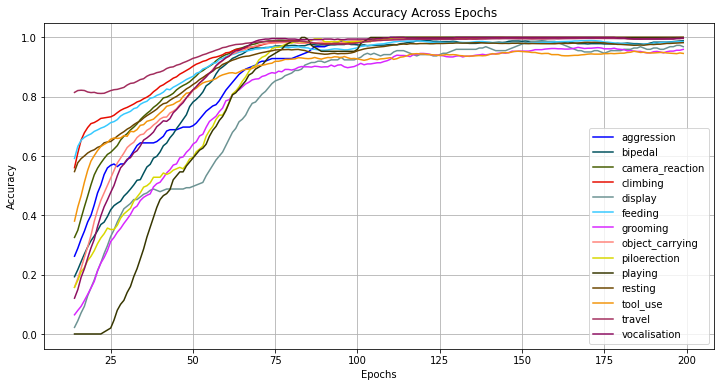

16 16


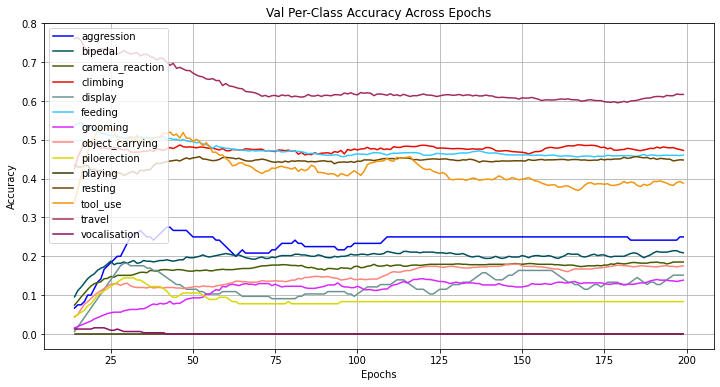

In [9]:
# Define class names
with open("../data/behaviours.txt", "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

exclude_tokens = [0, 15]  # Exclude SOS and PAD tokens

# Plot with different smoothing windows
smoothing_windows = [15]
for window in smoothing_windows:
    plot_per_class_accuracy(
        train_predictions,
        train_targets,
        train_masks,
        class_names=["SOS"] + behaviours + ["PAD"],
        smoothing_window=window,
        exclude_tokens=exclude_tokens,
        split="train",
    )

    plot_per_class_accuracy(
        val_predictions,
        val_targets,
        val_masks,
        class_names=["SOS"] + behaviours + ["PAD"],
        smoothing_window=window,
        exclude_tokens=exclude_tokens,
        split="val",
    )

In [10]:
def calculate_per_class_accuracy(
    predictions,
    targets,
    masks,
    epoch,
    class_names=None,
    exclude_tokens=[0, 15],
    return_average=False,
):
    E, N, S = predictions.shape
    num_classes = np.max(targets) + 1  # Assuming class indices start from 0

    # Use default class names if not provided
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]
    elif len(class_names) != num_classes:
        raise ValueError(
            "The number of class names must match the number of classes in the data."
        )

    # Initialize array to store accuracies
    accuracies = np.zeros(num_classes)

    # Calculate accuracies for each class given epoch
    for class_idx in range(num_classes):
        if class_idx not in exclude_tokens:
            class_mask = (targets[epoch] == class_idx) & masks[epoch]
            correct = (predictions[epoch] == targets[epoch]) & class_mask
            total = np.sum(class_mask)
            if total > 0:
                accuracies[class_idx] = np.sum(correct) / total

    # Create results dictionary, excluding the specified tokens
    results_dict = {
        class_names[i]: accuracies[i]
        for i in range(num_classes)
        if i not in exclude_tokens
    }

    if return_average:
        # Calculate average accuracy, excluding the specified tokens
        avg_accuracy = np.mean(
            [acc for i, acc in enumerate(accuracies) if i not in exclude_tokens]
        )
        return results_dict, avg_accuracy
    else:
        return results_dict

Text(0.5, 1.0, 'Per-Class Accuracy at Epoch 200')

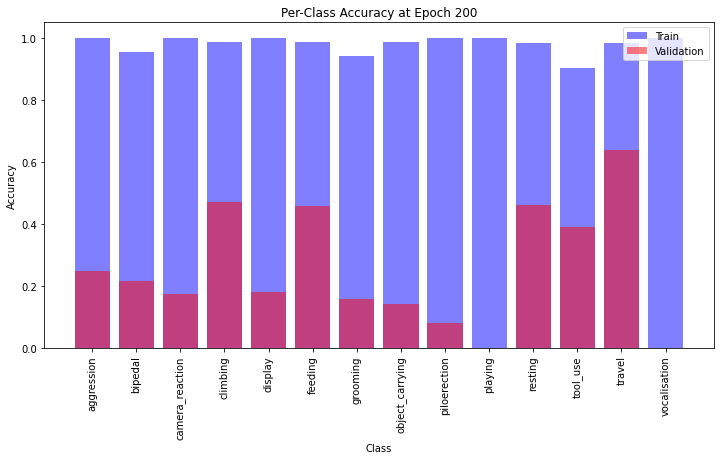

In [11]:
train_per_class_acc = calculate_per_class_accuracy(
    train_predictions,
    train_targets,
    train_masks,
    100,
    class_names=["<sos>"] + behaviours + ["<pad>"],
)
val_per_class_acc = calculate_per_class_accuracy(
    val_predictions,
    val_targets,
    val_masks,
    100,
    class_names=["<sos>"] + behaviours + ["<pad>"],
)

# Plot the results
plt.figure(figsize=(12, 6))

plt.bar(
    train_per_class_acc.keys(),
    train_per_class_acc.values(),
    color="blue",
    alpha=0.5,
    label="Train",
)
plt.bar(
    val_per_class_acc.keys(),
    val_per_class_acc.values(),
    color="red",
    alpha=0.5,
    label="Validation",
)

plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Per-Class Accuracy at Epoch 200")

**Sequence Statistics**

In [12]:
def get_seq_len(x):
    count = 0
    for elem in x:
        if not elem == -1:
            count += 1
    return count


def get_acc_per_seq_len(predictions, targets, masks, partition, epoch):

    target_df = pd.DataFrame(
        {
            "targets": list(targets[epoch]),
            "predictions": list(predictions[epoch]),
            "masks": list(masks[epoch]),
        }
    )

    # Apply mask to predictions
    target_df["masked_predictions"] = target_df.apply(
        lambda x: [
            x["predictions"][i] if x["masks"][i] else -1
            for i in range(len(x["predictions"]))
        ],
        axis=1,
    )

    # Calculate gt sequence lengths
    target_df["gt_seq_len"] = target_df["targets"].apply(lambda x: get_seq_len(x))

    # Calculate masked sequence lengths
    target_df["masked_seq_len"] = target_df["masked_predictions"].apply(
        lambda x: get_seq_len(x)
    )

    # Per sequence accuracy
    target_df["seq_accuracy"] = target_df.apply(
        lambda x: np.mean(
            [
                x["targets"][i] == x["masked_predictions"][i]
                for i in range(len(x["targets"]))
                if x["masks"][i]
            ]
        ),
        axis=1,
    )

    # Calculate average accuracy per gt sequence_len
    target_df.groupby("masked_seq_len")["seq_accuracy"].mean().plot(
        kind="bar", title=f"Average Accuracy per GT Sequence Length ({partition})"
    )

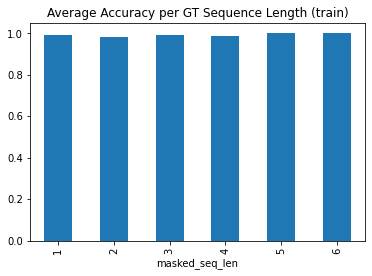

In [13]:
get_acc_per_seq_len(train_predictions, train_targets, train_masks, "train", 199)

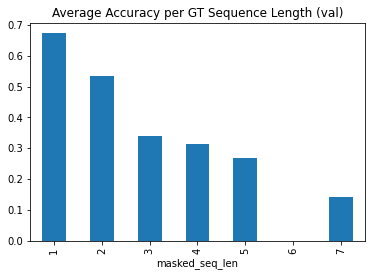

In [14]:
get_acc_per_seq_len(val_predictions, val_targets, val_masks, "val", 199)

In [15]:
def get_target_df(predictions, targets, masks, partition, epoch):
    target_df = pd.DataFrame(
        {
            "targets": list(targets[epoch]),
            "predictions": list(predictions[epoch]),
            "masks": list(masks[epoch]),
        }
    )
    return target_df


def plot_class_distribution(df, elements, partition, class_names):
    num_elements = len(elements)
    num_cols = (
        3  # You can change this value to adjust the number of columns in the grid
    )
    num_rows = (
        num_elements + num_cols - 1
    ) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, element in enumerate(elements):
        ax = axes[i]
        # Filter for padding elements
        filtered_df = df[df["targets"].apply(lambda x: x[element] != -1)]

        # Plot the class distribution of the element
        sns.histplot(
            filtered_df["targets"].apply(lambda x: x[element]),
            bins=np.arange(len(class_names) + 1),
            discrete=True,
            color="blue",
            alpha=0.5,
            label="Ground Truth",
            ax=ax,
        )

        # Put class names on the x-axis
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha="right")
        ax.set_xlabel("Class")
        ax.set_ylabel("Count")
        ax.legend()
        ax.set_title(f"Class Distribution of Element {element} ({partition})")

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

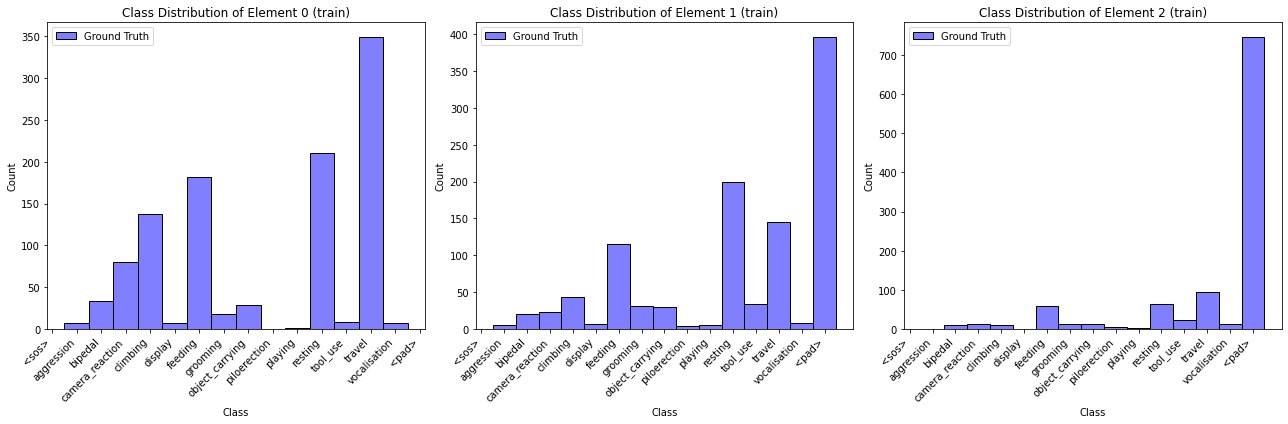

In [16]:
tgt_df = get_target_df(train_predictions, train_targets, train_masks, "train", 149)
plot_class_distribution(tgt_df, [0, 1, 2], "train", ["<sos>"] + behaviours + ["<pad>"])

In [17]:
# Write a function to calculate per class accuracy for each element and plot the results
def plot_per_class_accuracy_per_element(
    predictions, targets, masks, partition, epoch, elements
):

    target_df = get_target_df(predictions, targets, masks, partition, epoch)

    for i, element in enumerate(elements):
        target_df[f"{element}_element_pred"] = target_df.apply(
            lambda x: x["predictions"][i] if x["masks"][i] else np.nan, axis=1
        )

        target_df[f"{element}_element_gt"] = target_df["targets"].apply(
            lambda x: x[i] if x[i] != -1 else np.nan
        )
    # Generate subplots based on the number of elements
    num_elements = len(elements)
    num_cols = (
        3  # You can change this value to adjust the number of columns in the grid
    )
    num_rows = (
        num_elements + num_cols - 1
    ) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, element in enumerate(elements):

        ax = axes[i]

        # Filter for padding elements
        filtered_df = target_df[target_df[f"{element}_element_pred"].notnull()]

        # Convert predictions and targets to tensors
        preds = torch.tensor(
            filtered_df[f"{element}_element_pred"].values, dtype=torch.long
        )
        targets = torch.tensor(
            filtered_df[f"{element}_element_gt"].values, dtype=torch.long
        )

        # Calculate per class accuracy
        from torchmetrics.functional import accuracy

        try:
            per_class_accuracy = accuracy(
                preds=preds,
                target=targets,
                num_classes=len(behaviours) + 2,
                average=None,
            )
        except:
            raise ValueError(
                "The number of classes in the data does not match the number of classes in the class names."
            )

        # Replace NaN values with 0
        per_class_accuracy[torch.isnan(per_class_accuracy)] = 0

        # Average accuracy
        avg_per_class_accuracy = per_class_accuracy.mean().item()

        # Overall accuracy
        from sklearn.metrics import accuracy_score

        overall_accuracy = accuracy_score(
            filtered_df[f"{element}_element_gt"], filtered_df[f"{element}_element_pred"]
        )

        # Plot the per class accuracy
        pd.Series(per_class_accuracy).plot(kind="bar", ax=ax)
        ax.set_xlabel("Class")
        ax.set_ylabel("Accuracy")
        ax.set_title(
            f"{partition.capitalize()} Per-Class Accuracy of {element.capitalize()} (Acc: {overall_accuracy:.2f}, C-Avg: {avg_per_class_accuracy:.2f})"
        )
        # Put class names on the x-axis
        ax.set_xticks(np.arange(len(behaviours) + 2))
        ax.set_xticklabels(["<sos>"] + behaviours + ["<pad>"], rotation=45, ha="right")

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

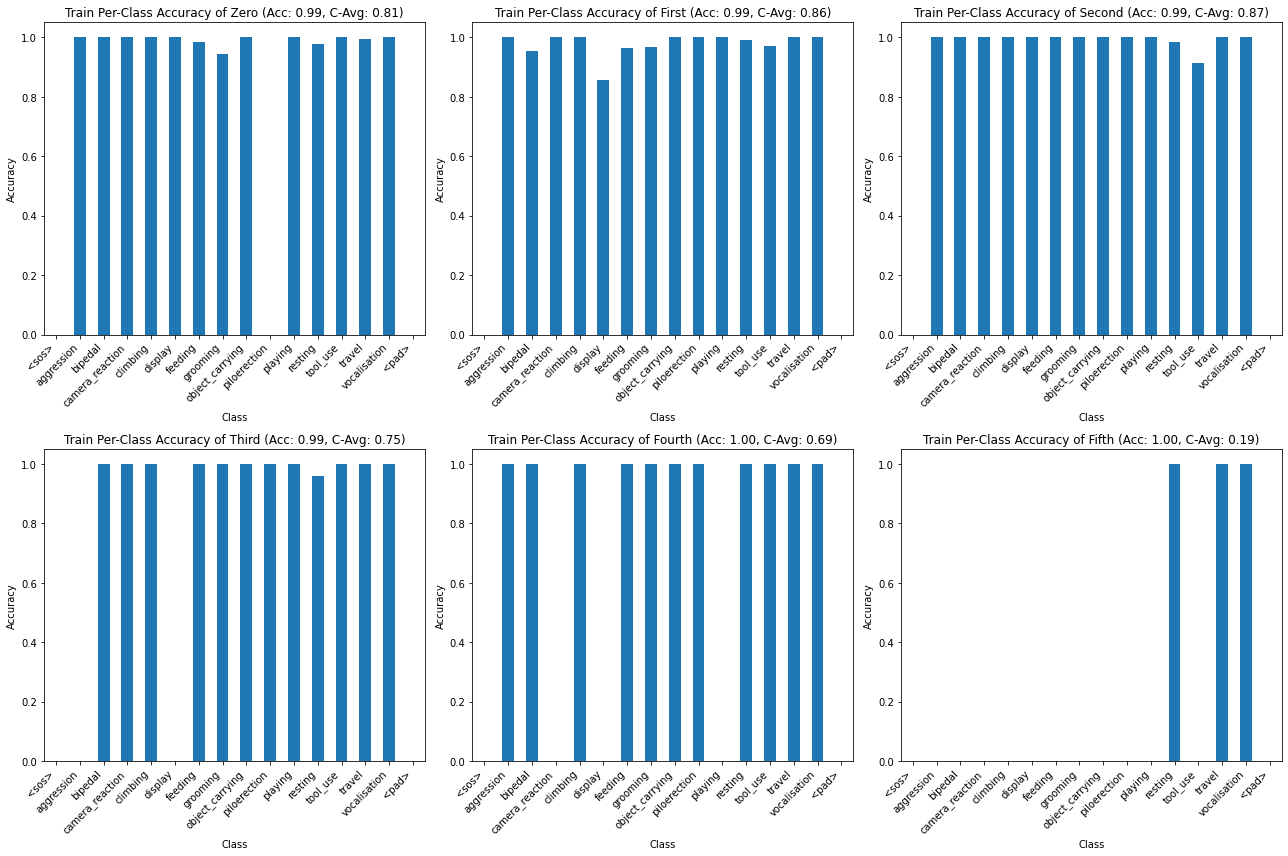

In [18]:
elements = ["zero", "first", "second", "third", "fourth", "fifth"]

plot_per_class_accuracy_per_element(
    train_predictions, train_targets, train_masks, "train", 199, elements
)

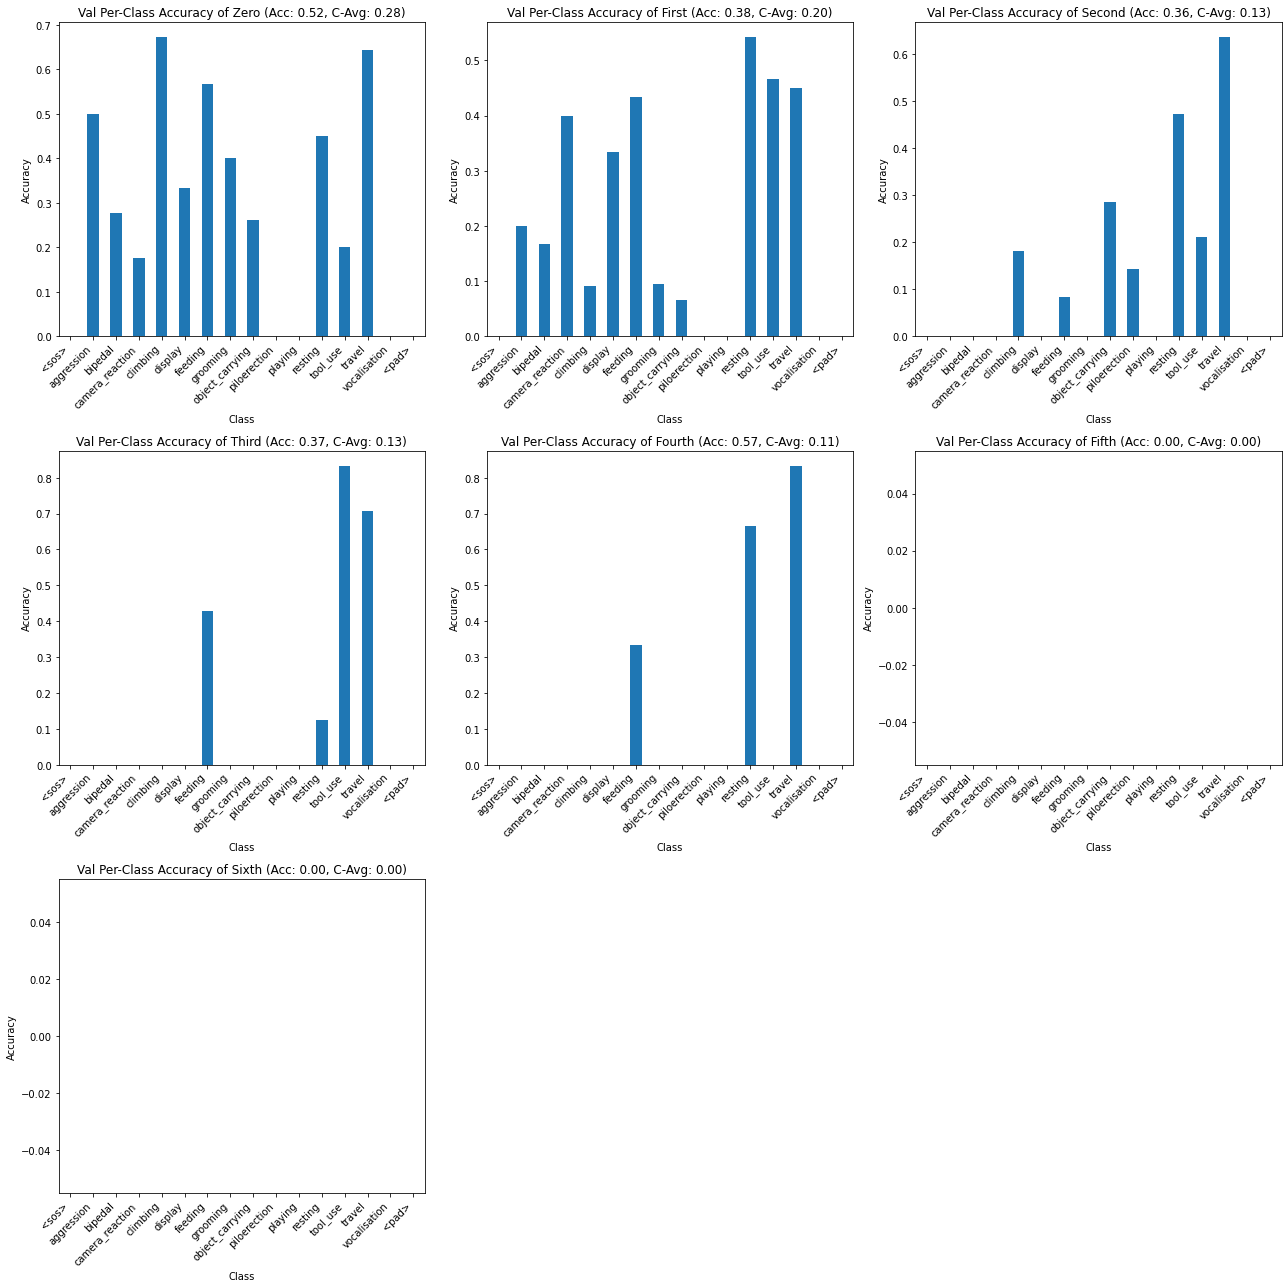

In [19]:
elements = ["zero", "first", "second", "third", "fourth", "fifth", "sixth"]

plot_per_class_accuracy_per_element(
    val_predictions, val_targets, val_masks, "val", 199, elements
)

**Transition Matrix**

In [20]:
def calculate_transition_matrix(input_sequences, exclude_special_tokens=False):
    # Get the number of unique elements (assuming elements are integers starting from 0)
    num_classes = 16  # Includes SOS (0) and PAD (15)

    # Initialize the transition count matrix
    transition_counts = torch.zeros((num_classes, num_classes), dtype=torch.float)

    # Count transitions
    for sequence in input_sequences:
        if len(sequence) == 1:
            from_state = sequence[0].item()
            to_state = sequence[0].item()
            if not (
                exclude_special_tokens
                and (from_state in [0, 15] or to_state in [0, 15])
            ):
                transition_counts[from_state, to_state] += 1
        else:
            # Count transitions in this sequence
            for i in range(len(sequence) - 1):
                from_state = sequence[i].item()
                to_state = sequence[i + 1].item()
                if not (
                    exclude_special_tokens
                    and (from_state in [0, 15] or to_state in [0, 15])
                ):
                    transition_counts[from_state, to_state] += 1

    # Normalize to get probabilities
    row_sums = transition_counts.sum(dim=1, keepdim=True)
    transition_matrix = transition_counts / row_sums

    # Handle division by zero
    transition_matrix = torch.nan_to_num(transition_matrix, nan=0.0)

    if exclude_special_tokens:
        # Remove rows and columns corresponding to SOS and PAD tokens
        mask = torch.ones(num_classes, dtype=bool)
        mask[0] = False  # SOS token
        mask[15] = False  # PAD token
        transition_matrix = transition_matrix[mask][:, mask]

    return transition_matrix


def transition_matrix_at_epoch(input_sequences, masks, epoch):
    masked_sequences = []
    for i, (p, m) in enumerate(zip(input_sequences[epoch], masks[epoch])):
        masked_sequences.append(p[m])
    return calculate_transition_matrix(masked_sequences, exclude_special_tokens=True)

Text(0.5, 1.0, 'Val: Predicted Transition Matrix')

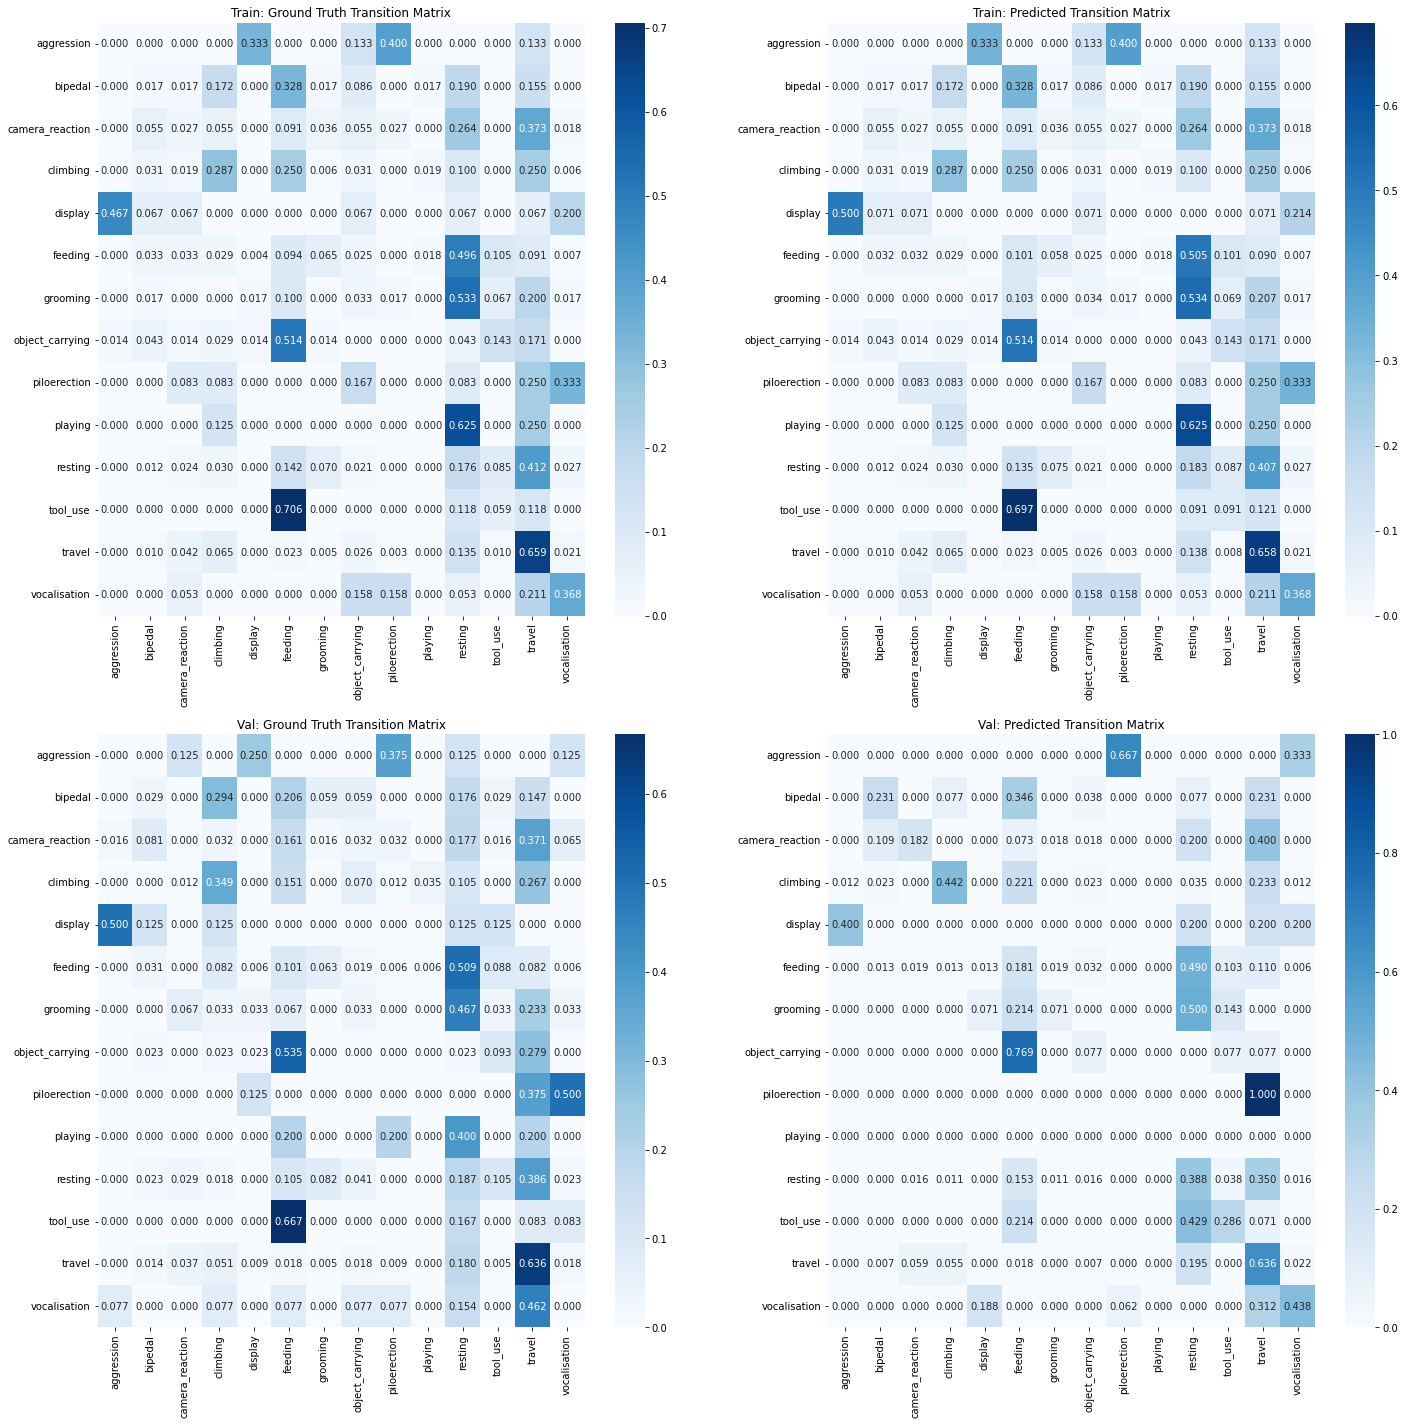

In [21]:
train_gt_transitions = transition_matrix_at_epoch(train_targets, train_masks, 199)
train_pred_transitions = transition_matrix_at_epoch(train_predictions, train_masks, 199)
val_gt_transitions = transition_matrix_at_epoch(val_targets, val_masks, 199)
val_pred_transitions = transition_matrix_at_epoch(val_predictions, val_masks, 199)

fig, ax = plt.subplots(2, 2, figsize=(24, 24))
sns.heatmap(
    train_gt_transitions,
    annot=True,
    xticklabels=behaviours,
    yticklabels=behaviours,
    ax=ax[0][0],
    cmap="Blues",
    fmt=".3f",
)
sns.heatmap(
    train_pred_transitions,
    annot=True,
    xticklabels=behaviours,
    yticklabels=behaviours,
    ax=ax[0][1],
    cmap="Blues",
    fmt=".3f",
)
sns.heatmap(
    val_gt_transitions,
    annot=True,
    xticklabels=behaviours,
    yticklabels=behaviours,
    ax=ax[1][0],
    cmap="Blues",
    fmt=".3f",
)
sns.heatmap(
    val_pred_transitions,
    annot=True,
    xticklabels=behaviours,
    yticklabels=behaviours,
    ax=ax[1][1],
    cmap="Blues",
    fmt=".3f",
)
ax[0][0].set_title("Train: Ground Truth Transition Matrix")
ax[0][1].set_title("Train: Predicted Transition Matrix")
ax[1][0].set_title("Val: Ground Truth Transition Matrix")
ax[1][1].set_title("Val: Predicted Transition Matrix")

In [22]:
# Transition matrix over time
def transition_matrix_over_time(input_sequences, masks, epochs):
    transition_matrices = torch.zeros(len(epochs), len(behaviours), len(behaviours))
    for e, epoch in enumerate(epochs):
        masked_sequences = []
        for i, (p, m) in enumerate(zip(input_sequences[epoch], masks[epoch])):
            masked_sequences.append(p[m])
        transition_matrices[e] = calculate_transition_matrix(
            masked_sequences, exclude_special_tokens=True
        )
    return transition_matrices


def plot_transition_matrices(transition_matrices, epochs):
    # Create a grid of subplots with max 3 columns
    num_plots = len(epochs)
    num_cols = min(num_plots, 3)
    num_rows = (num_plots - 1) // num_cols + 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 10 * num_rows))

    # Plot each transition matrix
    for i, epoch in enumerate(epochs):
        row = i // num_cols
        col = i % num_cols
        sns.heatmap(
            transition_matrices[i],
            annot=True,
            xticklabels=behaviours,
            yticklabels=behaviours,
            ax=ax[row][col],
            cmap="Blues",
            fmt=".2f",
        )
        ax[row][col].set_title(f"Epoch {epoch}")

    # Remove empty subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(ax.flatten()[i])

    plt.tight_layout()
    plt.show()

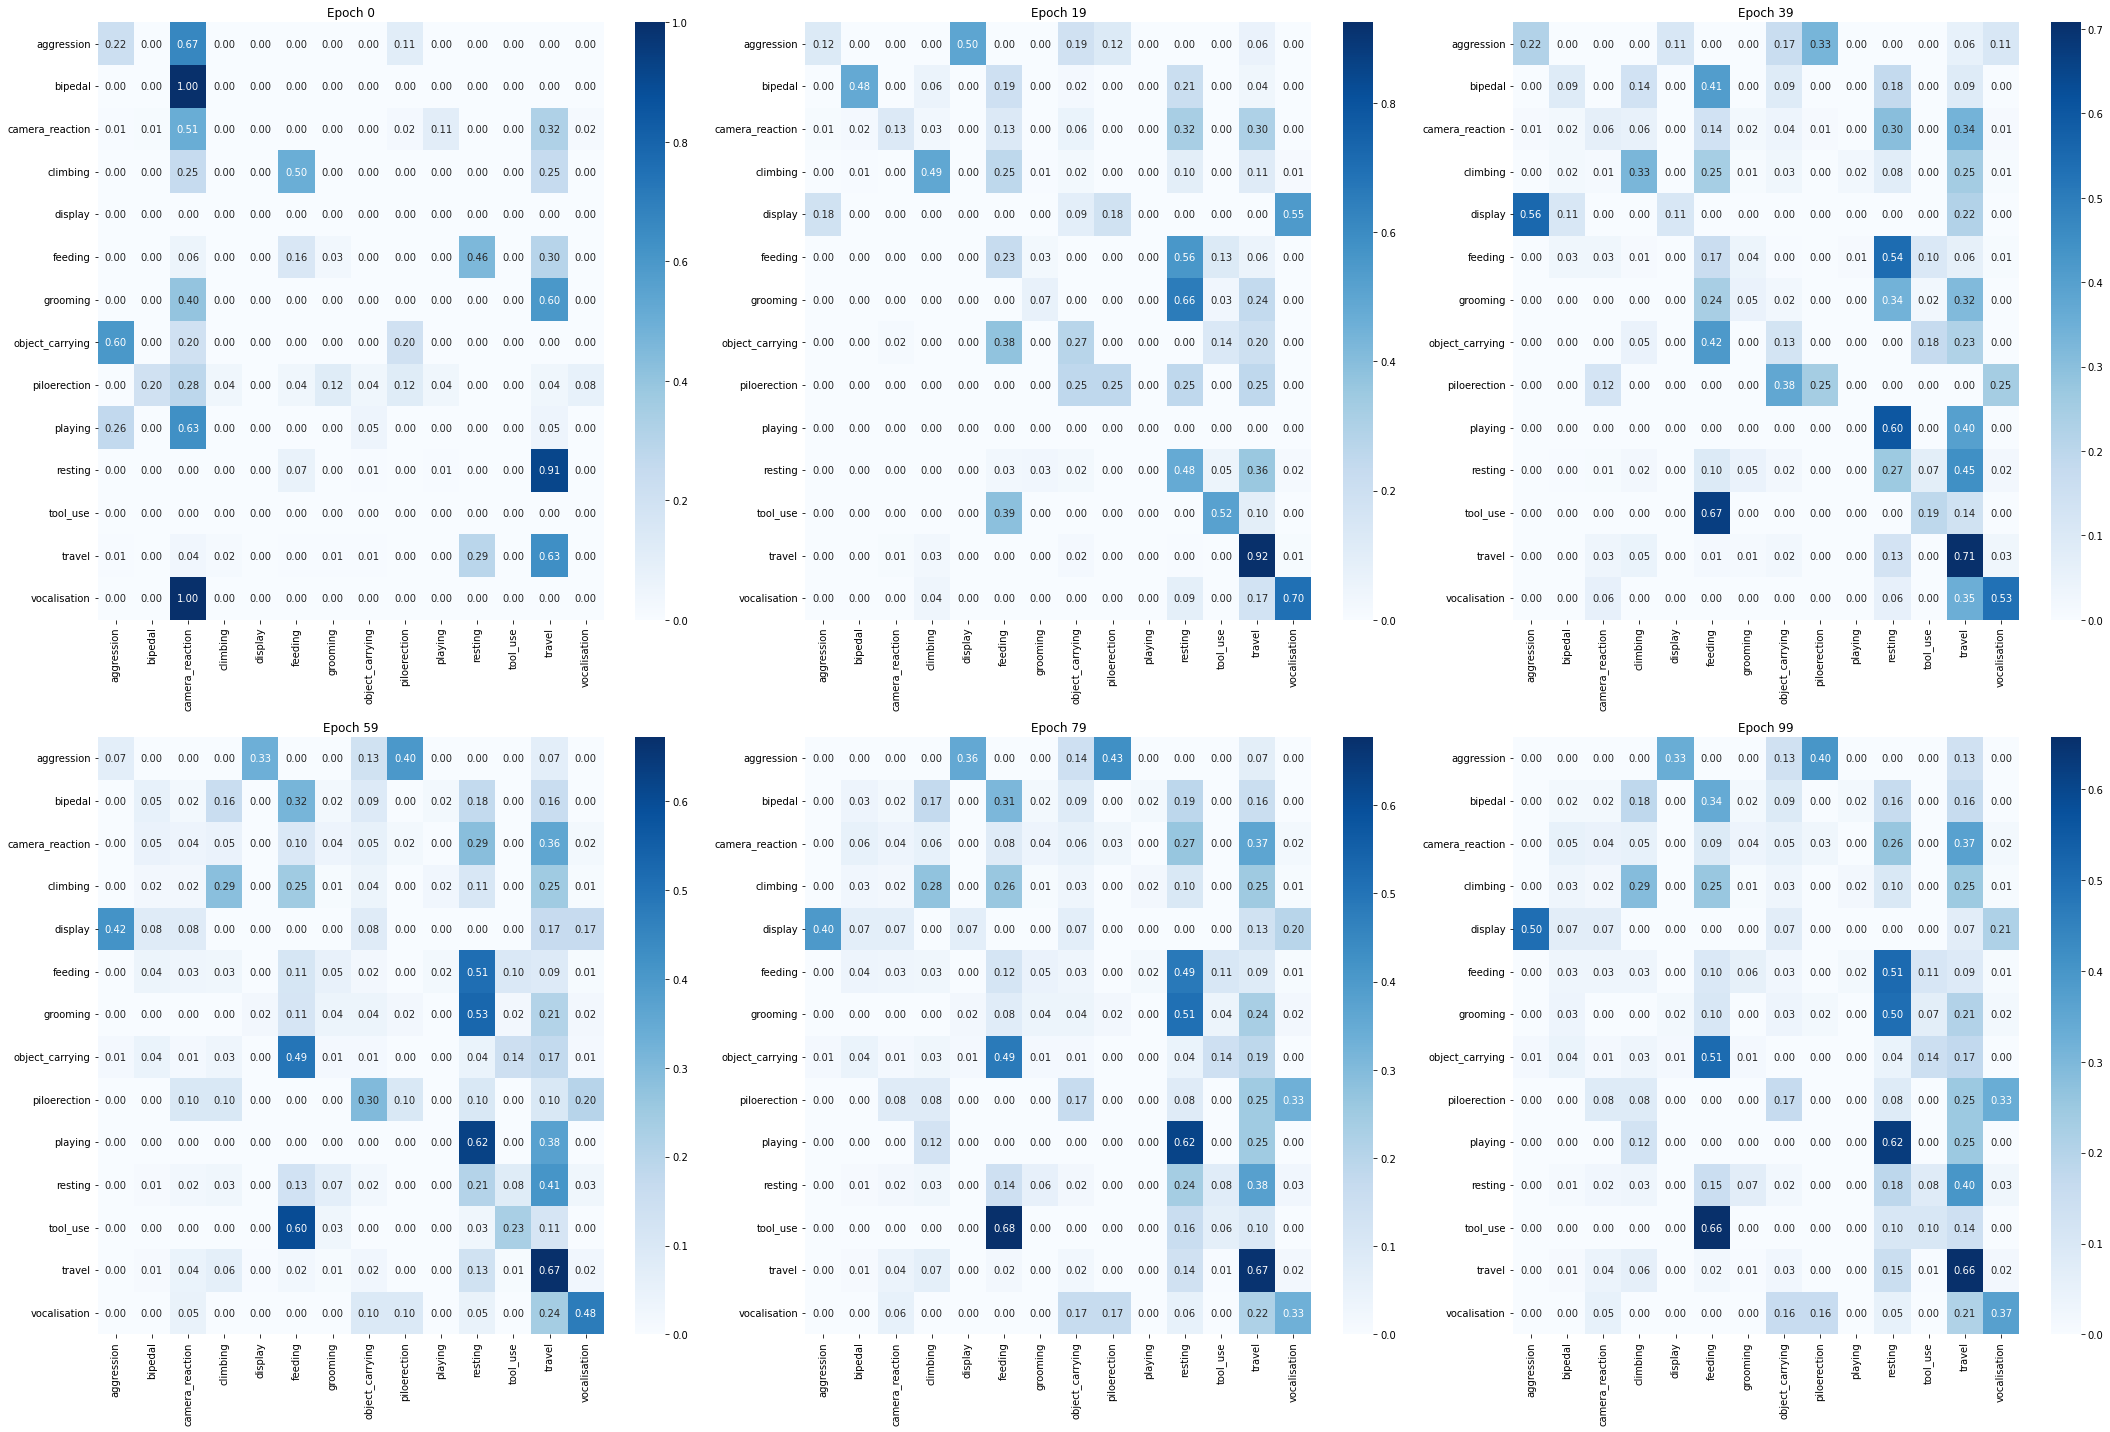

In [23]:
epochs = [0, 19, 39, 59, 79, 99]

train_transition_matrices = transition_matrix_over_time(
    train_predictions, train_masks, epochs
)

plot_transition_matrices(train_transition_matrices, epochs)

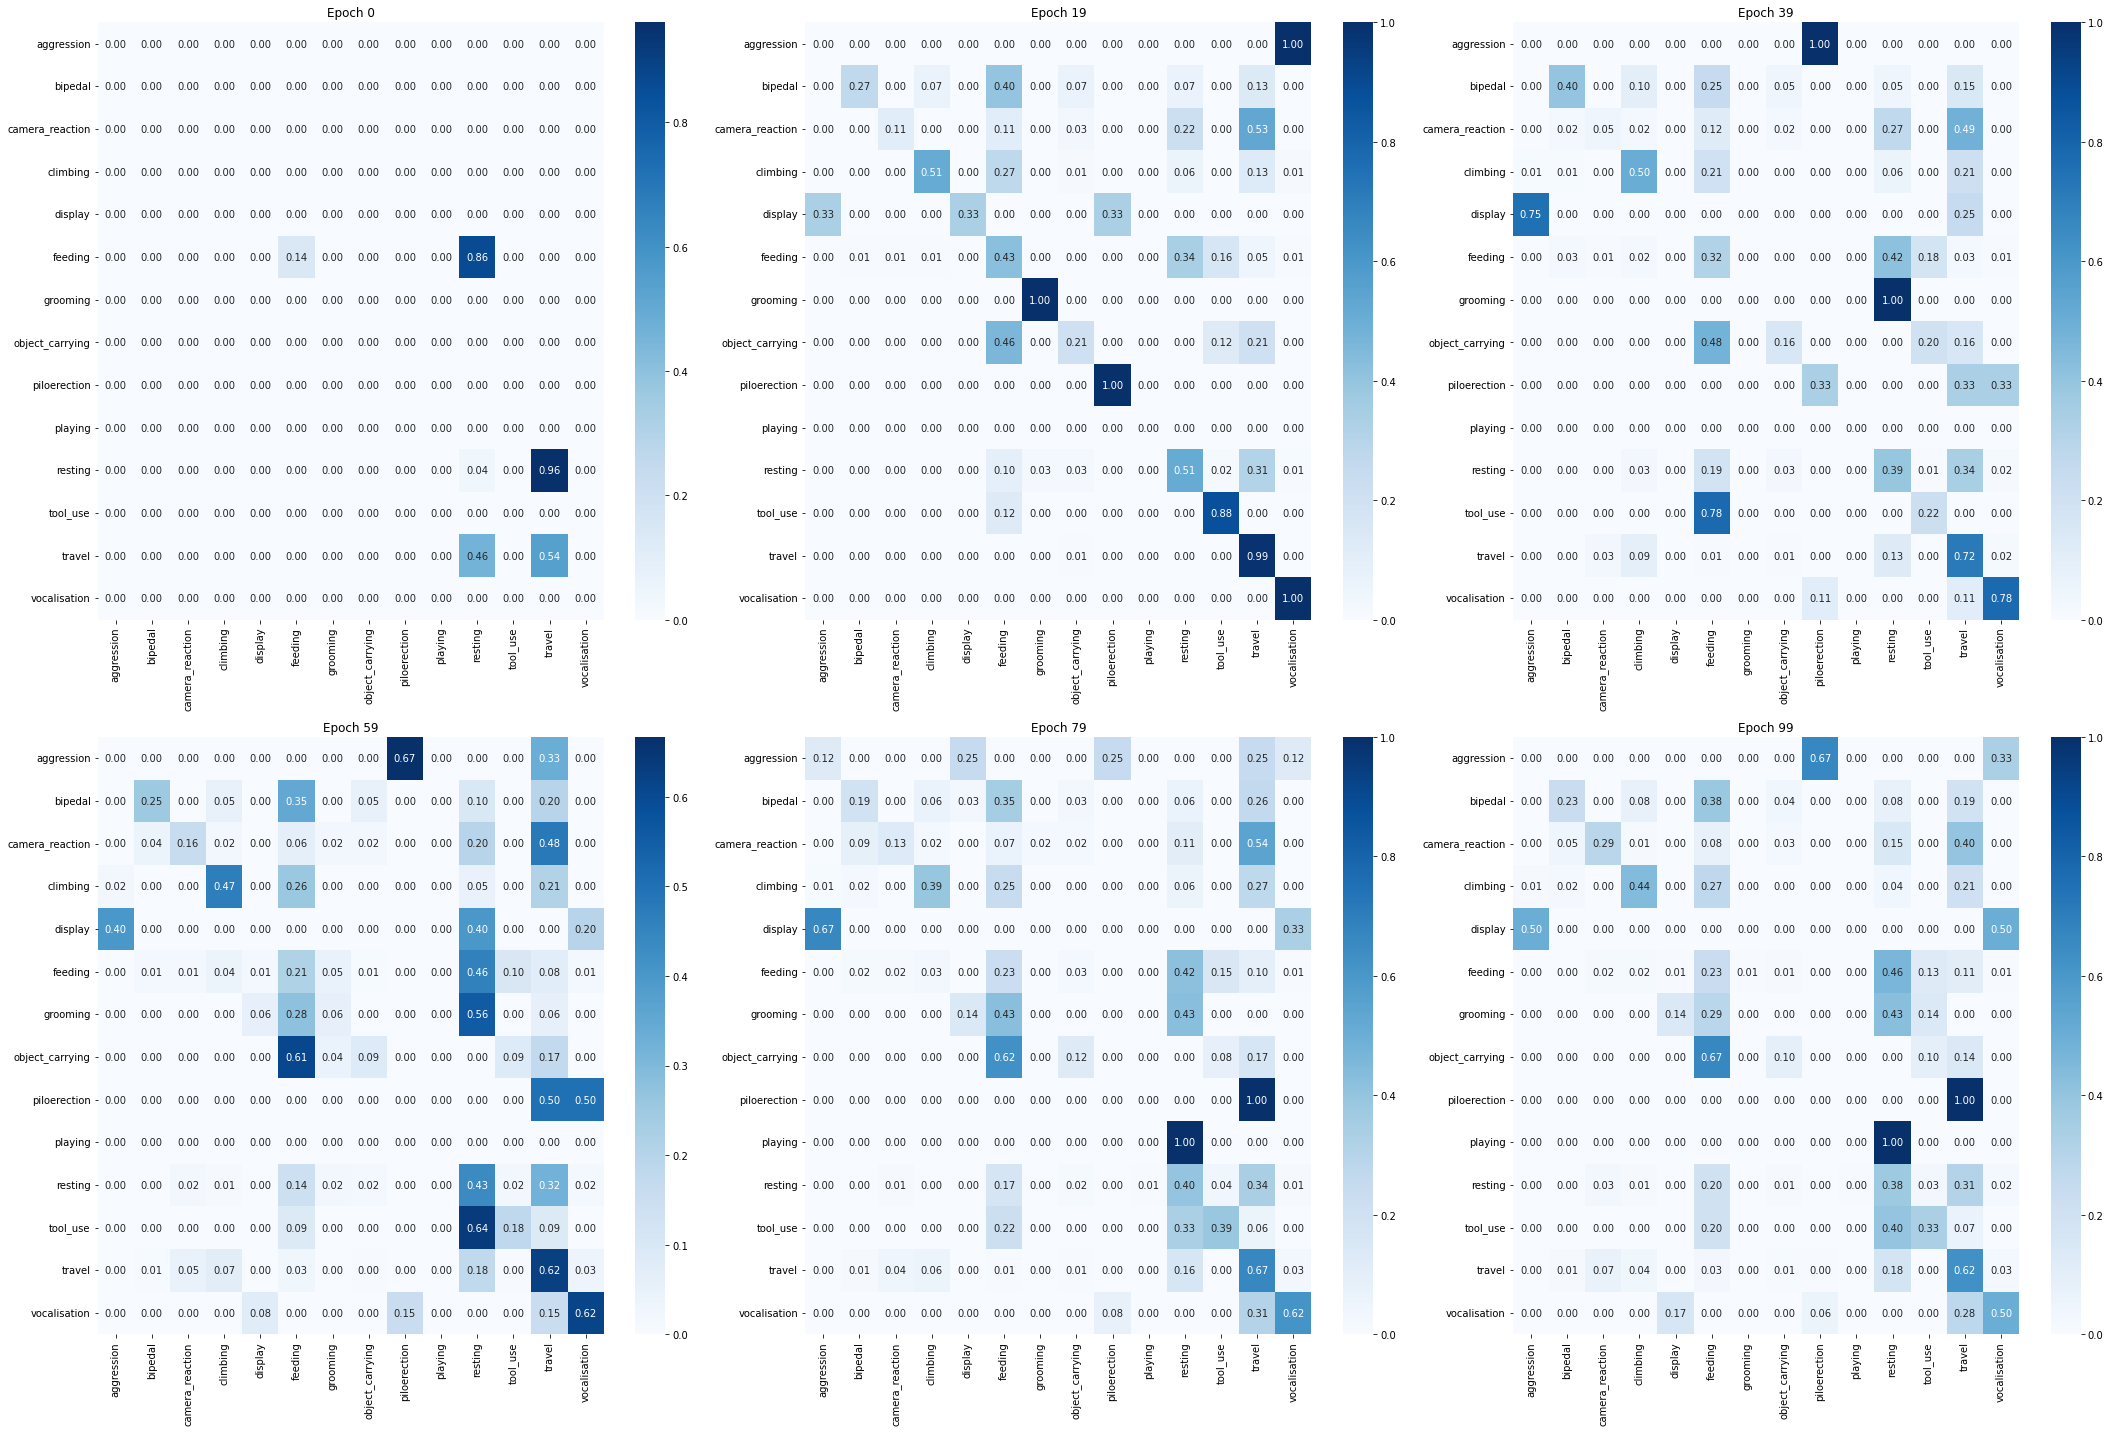

In [24]:
val_transition_matrices = transition_matrix_over_time(
    val_predictions, val_masks, epochs
)
plot_transition_matrices(val_transition_matrices, epochs)